# IBM Applied Data Science Capstone Project - The Battle of Neighborhoods

## Problem Statement: To identify the best location to open a new Indian Restaurant in Toronto. 
    
    

## Part-1: Get Data on Toronto Neighborhoods - Borough, Neighborhood, Latituge and Longitude

In [6]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

print('Libraries imported.')

Libraries imported.


In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

In [8]:
data = []
for tr in soup.tbody.find_all('tr'):
    data.append([ td.get_text().strip() for td in tr.find_all('td')])

In [9]:
df_toronto = pd.DataFrame(data, columns=['PostalCode','Borough','Neighborhood'])

In [10]:
df_toronto.head()

,PostalCode,Borough,Neighborhood
0,None,None,None
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [11]:
df_toronto = df_toronto.dropna()

In [12]:
empty = 'Not assigned'
df_toronto = df_toronto[(df_toronto.PostalCode != empty ) & (df_toronto.Borough != empty) & (df_toronto.Neighborhood != empty)]

In [13]:
df_toronto.head()

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor


In [14]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df_toronto.groupby(['PostalCode', 'Borough'])
df_toronto2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [15]:
df_toronto2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [16]:
df_toronto2.shape

(102, 3)

### Get latitude and longitude data

In [17]:
!pip install geocoder
import geocoder

     |████████████████████████████████| 102kB 12.6MB/s ta 0:00:01


In [18]:
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords
    
get_latlng('M4G')

[43.70949500000006, -79.36398897099997]

In [19]:
postal_codes = df_toronto2['PostalCode']  
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

In [20]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_toronto2['Latitude'] = df_coords['Latitude']
df_toronto2['Longitude'] = df_coords['Longitude']

In [29]:
df_toronto2.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726276,-79.263625
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713054,-79.285055
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.724235,-79.227925
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696770,-79.259967


### So there are 102 Neighborhoods in Toronto

In [22]:
df_toronto2.shape

(102, 5)

## Part-2: Explore Toronto Neighborhoods for Indian Restaurants

### Use FourSquare API to get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category

In [24]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    VERSION = '20191208'
    CLIENT_ID = 'DZQAVAYYXABUESFPSLUB4SXRCGTVABIGTUHI02SJ3RKY1OL5'
    CLIENT_SECRET = 'GQSOI3QBIR0P2LIJABPYZTS2LINOTNZ3RGEKRAPZR1PGT25G'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Define a function to get venue details like like count , rating , tip counts for a given venue id

In [25]:
def get_venue_details(venue_id):
        
    VERSION = '20191208'
    CLIENT_ID = 'DZQAVAYYXABUESFPSLUB4SXRCGTVABIGTUHI02SJ3RKY1OL5'
    CLIENT_SECRET = 'GQSOI3QBIR0P2LIJABPYZTS2LINOTNZ3RGEKRAPZR1PGT25G'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get Data for Indian resturants in each Neighborhood

In [30]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_toronto2.values.tolist():
    PostalCode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_toronto2),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_toronto = indian_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 102 ) Indian Restaurants in Malvern, Rouge, Scarborough:0
( 2 / 102 ) Indian Restaurants in Highland Creek, Port Union, Rouge Hill, Scarborough:0
( 3 / 102 ) Indian Restaurants in Guildwood, Morningside, West Hill, Scarborough:0
( 4 / 102 ) Indian Restaurants in Woburn, Scarborough:2
( 5 / 102 ) Indian Restaurants in Cedarbrae, Scarborough:4
( 6 / 102 ) Indian Restaurants in Scarborough Village, Scarborough:1
( 7 / 102 ) Indian Restaurants in East Birchmount Park, Ionview, Kennedy Park, Scarborough:0
( 8 / 102 ) Indian Restaurants in Clairlea, Golden Mile, Oakridge, Scarborough:0
( 9 / 102 ) Indian Restaurants in Cliffcrest, Cliffside, Scarborough Village West, Scarborough:0
( 10 / 102 ) Indian Restaurants in Birch Cliff, Cliffside West, Scarborough:0
( 11 / 102 ) Indian Restaurants in Dorset Park, Scarborough Town Centre, Wexford Heights, Scarborough:2
( 12 / 102 ) Indian Restaurants in Maryvale, Wexford, Scarborough:1
( 13 / 102 ) Indian Restaurants in Agincourt, Scarborough:0


In [33]:
indian_rest_toronto.head(50)

,Borough,Neighborhood,ID,Name
0,Scarborough,Woburn,4bd48a734e32d13a4254bf80,Govardhan Thal
1,Scarborough,Woburn,4c632edeedd320a19ad5ae29,Bombay Palace
2,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc
3,Scarborough,Cedarbrae,4bd48a734e32d13a4254bf80,Govardhan Thal
4,Scarborough,Cedarbrae,4c77fc87bd346dcb8c90f0ef,La Sani Grill
5,Scarborough,Cedarbrae,4c632edeedd320a19ad5ae29,Bombay Palace
6,Scarborough,Scarborough Village,4b6dbc8ef964a520fd8a2ce3,Anjappar Authentic Chettinadu Restaurant
7,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",5226562611d2cd49d83ef03b,Kairali
8,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",4bf96c435317a593a23a017f,Karaikudi Chettinad South Indian Restaurant
9,Scarborough,"Maryvale, Wexford",4c27cddd9fb5d13a8cab9857,Patna Kebab House


In [32]:
indian_rest_toronto.shape

(46, 4)

There are 46 Indian Restaurants in Toronto

## Part-3: Analyze Toronto Indian Restaurants

#### (a) Identify the Borough with the maximum number of Indian Restaurants

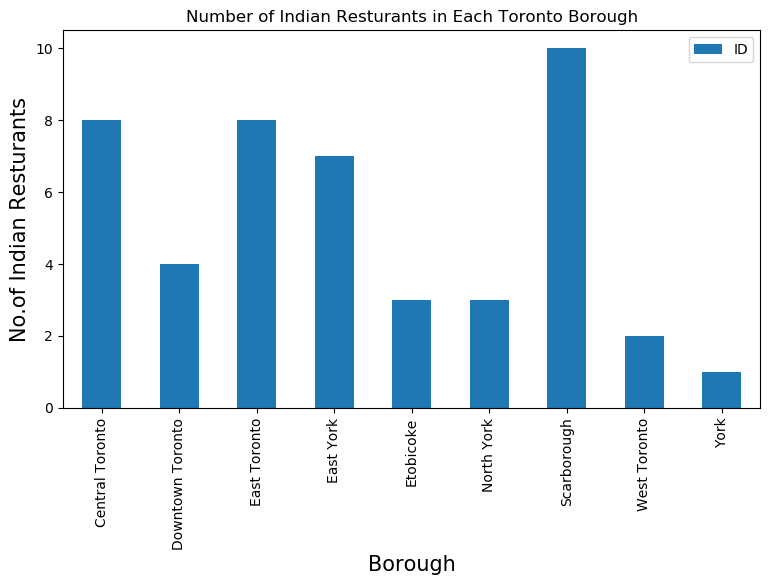

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants in Each Toronto Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### (b) Toronto Indian Restaurants with maximum likes, ratings, tips

In [36]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_toronto),')','processed')
    indian_rest_stats_toronto = indian_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID            Name  Likes  Rating  Tips
0  4bd48a734e32d13a4254bf80  Govardhan Thal      7     7.4     3
( 1 / 46 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 2 / 46 ) processed
                         ID             Name  Likes  Rating  Tips
0  4d6008f829ef236a8832a059  CANBE Foods Inc     22     8.2     8
( 3 / 46 ) processed
                         ID            Name  Likes  Rating  Tips
0  4bd48a734e32d13a4254bf80  Govardhan Thal      7     7.4     3
( 4 / 46 ) processed
                         ID           Name  Likes  Rating  Tips
0  4c77fc87bd346dcb8c90f0ef  La Sani Grill     12     6.6    12
( 5 / 46 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 6 / 46 ) processed
                         ID                                      Name  Likes  \
0  4b6dbc8ef964a520fd8a2ce3  Anjappar 

In [37]:

indian_rest_stats_toronto.head(50)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Woburn,4bd48a734e32d13a4254bf80,Govardhan Thal,7,7.4,3
1,Scarborough,Woburn,0,0,0,0.0,0
2,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc,22,8.2,8
3,Scarborough,Cedarbrae,4bd48a734e32d13a4254bf80,Govardhan Thal,7,7.4,3
4,Scarborough,Cedarbrae,4c77fc87bd346dcb8c90f0ef,La Sani Grill,12,6.6,12
5,Scarborough,Cedarbrae,0,0,0,0.0,0
6,Scarborough,Scarborough Village,4b6dbc8ef964a520fd8a2ce3,Anjappar Authentic Chettinadu Restaurant,21,8.5,10
7,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",5226562611d2cd49d83ef03b,Kairali,9,7.4,6
8,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",4bf96c435317a593a23a017f,Karaikudi Chettinad South Indian Restaurant,27,6.3,23
9,Scarborough,"Maryvale, Wexford",4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6


In [39]:
indian_rest_stats_toronto['Likes']=indian_rest_stats_toronto['Likes'].astype('float64')
indian_rest_stats_toronto['Tips']=indian_rest_stats_toronto['Tips'].astype('float64')

In [40]:
# Resturant with maximum Likes
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.9
Tips                                  75
Name: 38, dtype: object

In [41]:
# Resturant with maximum Rating
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Rating'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.9
Tips                                  75
Name: 38, dtype: object

In [42]:
# Resturant with maximum Tips
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.9
Tips                                  75
Name: 38, dtype: object

#### (c) Best Borough for Indian Food

In [44]:
toronto_borough_stats=indian_rest_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

In [46]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head(50)

,Borough,Average Rating
1,Downtown Toronto,8.275000
7,West Toronto,7.450000
0,Central Toronto,7.400000
4,Etobicoke,6.966667
2,East Toronto,6.137500
8,York,6.000000
6,Scarborough,5.980000
3,East York,5.900000
5,North York,4.433333


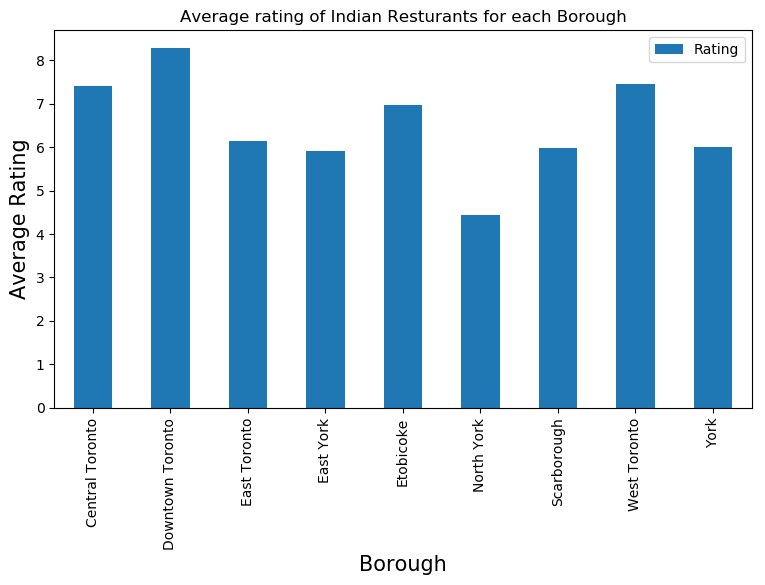

In [47]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Conclusion

### 1. There are a total of 46 Indian restaurants in Toronto with Scarborough having the most with 10 restaurants

### 2. The best indian restaurant in Torornto is Banjara Indian Cuisine in Downtown Toronto

### 3. The best borough for Indian restaurants is Downtown Toronto followed byCentral Toronto

### 4. Though Sacrborough has the most number of Indian restaurants, the average restaurant ratings is only 6.0. Hence, Scarboroug is an ideal location for openeing a new high quality restaurant.